In [1]:

import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/datasets/gmbiggan/historic-climate-data-hill-regian/All Historic Climate data Hill Region.csv


Library Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

Setup and Load Data

Load Data

In [4]:
df = pd.read_csv(
    '/kaggle/input/datasets/gmbiggan/historic-climate-data-hill-regian/All Historic Climate data Hill Region.csv',
    encoding='latin1'
)

df.head()


,YEAR,Day of the Year,Relative Huminidity,Precipitation (mm/day),Temperature at 2 Meters Maximum ©,Temperature at 2 Meters Minimum ©,Temperature at 2 Meters Range ©
0,1981,182,91.67,70.24,29.01,25.99,3.02
1,1981,183,89.04,42.67,29.86,26.67,3.19
2,1981,184,90.44,27.48,30.29,26.68,3.61
3,1981,185,86.97,14.46,30.70,26.42,4.28
4,1981,186,87.88,6.62,29.81,26.00,3.81


Convert Daily Data to Yearly Aggregates

In [5]:

print(df.columns.tolist())

print([col for col in df.columns if 'Temperature' in col or 'Minimum' in col])

['YEAR', 'Day of the Year', 'Relative Huminidity', 'Precipitation (mm/day)', 'Temperature at 2 Meters Maximum ©', ' Temperature at 2 Meters Minimum ©', 'Temperature at 2 Meters Range ©']
['Temperature at 2 Meters Maximum ©', ' Temperature at 2 Meters Minimum ©', 'Temperature at 2 Meters Range ©']


In [6]:
yearly_df = df.groupby('YEAR').agg({
    'Relative Huminidity': 'mean',  
    'Precipitation (mm/day)': 'sum',
    'Temperature at 2 Meters Maximum ©': 'mean',
    ' Temperature at 2 Meters Minimum ©': 'mean',  
    'Temperature at 2 Meters Range ©': 'mean'
}).reset_index()

yearly_df.columns = ['Year', 'Humidity_avg', 'Precip_total', 'Tmax_avg', 'Tmin_avg', 'Trange_avg']

print(yearly_df.shape)
yearly_df.tail()

(45, 6)


,Year,Humidity_avg,Precip_total,Tmax_avg,Tmin_avg,Trange_avg
40,2021,78.820055,3436.50,29.591260,22.400904,7.190356
41,2022,79.456849,2755.15,29.326219,22.120192,7.206027
42,2023,77.868849,3203.02,29.824630,22.496603,7.328027
43,2024,79.575546,4297.58,29.630765,22.495656,7.135109
44,2025,79.490137,4062.58,29.468658,22.670822,6.797836


Clean up column names first (remove leading/trailing spaces)

In [7]:

df.columns = df.columns.str.strip()

print(df.columns.tolist())

yearly_df = df.groupby('YEAR').agg({
    'Relative Huminidity': 'mean',
    'Precipitation (mm/day)': 'sum',
    'Temperature at 2 Meters Maximum ©': 'mean',
    'Temperature at 2 Meters Minimum ©': 'mean',  
    'Temperature at 2 Meters Range ©': 'mean'
}).reset_index()

yearly_df.columns = ['Year', 'Humidity_avg', 'Precip_total', 'Tmax_avg', 'Tmin_avg', 'Trange_avg']

print(yearly_df.shape)
yearly_df.tail()

['YEAR', 'Day of the Year', 'Relative Huminidity', 'Precipitation (mm/day)', 'Temperature at 2 Meters Maximum ©', 'Temperature at 2 Meters Minimum ©', 'Temperature at 2 Meters Range ©']
(45, 6)


,Year,Humidity_avg,Precip_total,Tmax_avg,Tmin_avg,Trange_avg
40,2021,78.820055,3436.50,29.591260,22.400904,7.190356
41,2022,79.456849,2755.15,29.326219,22.120192,7.206027
42,2023,77.868849,3203.02,29.824630,22.496603,7.328027
43,2024,79.575546,4297.58,29.630765,22.495656,7.135109
44,2025,79.490137,4062.58,29.468658,22.670822,6.797836


Exploratory Data Analysis (EDA)

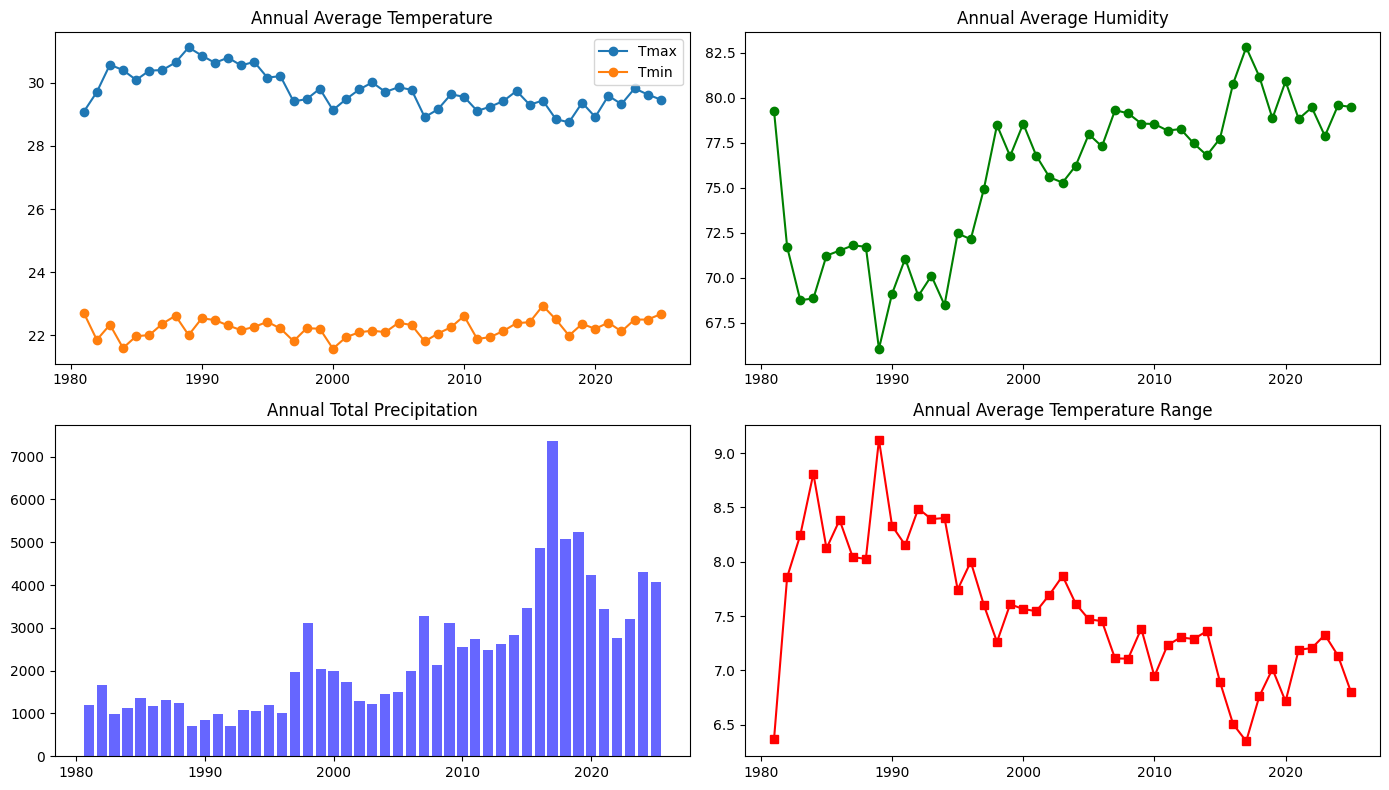

In [8]:
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
plt.plot(yearly_df.Year, yearly_df.Tmax_avg, 'o-', label='Tmax')
plt.plot(yearly_df.Year, yearly_df.Tmin_avg, 'o-', label='Tmin')
plt.title('Annual Average Temperature')
plt.legend()

plt.subplot(2,2,2)
plt.plot(yearly_df.Year, yearly_df.Humidity_avg, 'o-', color='green')
plt.title('Annual Average Humidity')

plt.subplot(2,2,3)
plt.bar(yearly_df.Year, yearly_df.Precip_total, color='blue', alpha=0.6)
plt.title('Annual Total Precipitation')

plt.subplot(2,2,4)
plt.plot(yearly_df.Year, yearly_df.Trange_avg, 's-', color='red')
plt.title('Annual Average Temperature Range')

plt.tight_layout()
plt.show()

Split Data for Training and Testing

In [9]:
train = yearly_df[yearly_df.Year <= 2015].copy()    #Train: 1981 – 2015
test = yearly_df[(yearly_df.Year >= 2016) & (yearly_df.Year <= 2025)].copy()  #test(Validation): 2016-2025
future_years = np.arange(2026, 2061).reshape(-1,1)   #Feature: 2026-2060

print(f"Train: {train.Year.min()}–{train.Year.max()}  ({len(train)} years)")
print(f"Test: {test.Year.min()}–{test.Year.max()}  ({len(test)} years)")
print(f"Future: 2026–2060  ({len(future_years)} years)")

Train: 1981–2015  (35 years)
Test: 2016–2025  (10 years)
Future: 2026–2060  (35 years)


 Linear Trend (baseline)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("="*60)
print("5.1 LINEAR TREND (BASELINE)")
print("="*60)

X_train = train.Year.values.reshape(-1,1)
X_test = test.Year.values.reshape(-1,1)

# Tmax
y_train = train.Tmax_avg.values
y_test = test.Tmax_avg.values
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f"Tmax – MAE: {mae:.2f}°C, RMSE: {rmse:.2f}°C, R²: {r2:.3f}")

# Tmin
y_train = train.Tmin_avg.values
y_test = test.Tmin_avg.values
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f"Tmin – MAE: {mae:.2f}°C, RMSE: {rmse:.2f}°C, R²: {r2:.3f}")

# Trange
y_train = train.Trange_avg.values
y_test = test.Trange_avg.values
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f"Trange – MAE: {mae:.2f}°C, RMSE: {rmse:.2f}°C, R²: {r2:.3f}")

# Precipitation
y_train = train.Precip_total.values
y_test = test.Precip_total.values
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f"Precipitation – MAE: {mae:.2f} mm, RMSE: {rmse:.2f} mm, R²: {r2:.3f}")

# Humidity
y_train = train.Humidity_avg.values
y_test = test.Humidity_avg.values
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f"Humidity – MAE: {mae:.2f}%, RMSE: {rmse:.2f}%, R²: {r2:.3f}")

5.1 LINEAR TREND (BASELINE)
Tmax – MAE: 0.41°C, RMSE: 0.46°C, R²: -0.767
Tmin – MAE: 0.31°C, RMSE: 0.37°C, R²: -1.063
Trange – MAE: 0.32°C, RMSE: 0.39°C, R²: -0.583
Precipitation – MAE: 1466.21 mm, RMSE: 1937.58 mm, R²: -1.434
Humidity – MAE: 1.92%, RMSE: 2.12%, R²: -1.421


Polynomial Trend

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

print("\n" + "="*60)
print("5.2 POLYNOMIAL TREND (DEGREE=2)")
print("="*60)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Tmax
y_train = train.Tmax_avg.values
y_test = test.Tmax_avg.values
model = LinearRegression()
model.fit(X_train_poly, y_train)
pred = model.predict(X_test_poly)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f"Tmax – MAE: {mae:.2f}°C, RMSE: {rmse:.2f}°C, R²: {r2:.3f}")

# Tmin
y_train = train.Tmin_avg.values
y_test = test.Tmin_avg.values
model = LinearRegression()
model.fit(X_train_poly, y_train)
pred = model.predict(X_test_poly)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f"Tmin – MAE: {mae:.2f}°C, RMSE: {rmse:.2f}°C, R²: {r2:.3f}")

# Trange
y_train = train.Trange_avg.values
y_test = test.Trange_avg.values
model = LinearRegression()
model.fit(X_train_poly, y_train)
pred = model.predict(X_test_poly)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f"Trange – MAE: {mae:.2f}°C, RMSE: {rmse:.2f}°C, R²: {r2:.3f}")

# Precipitation
y_train = train.Precip_total.values
y_test = test.Precip_total.values
model = LinearRegression()
model.fit(X_train_poly, y_train)
pred = model.predict(X_test_poly)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f"Precipitation – MAE: {mae:.2f} mm, RMSE: {rmse:.2f} mm, R²: {r2:.3f}")

# Humidity
y_train = train.Humidity_avg.values
y_test = test.Humidity_avg.values
model = LinearRegression()
model.fit(X_train_poly, y_train)
pred = model.predict(X_test_poly)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f"Humidity – MAE: {mae:.2f}%, RMSE: {rmse:.2f}%, R²: {r2:.3f}")


5.2 POLYNOMIAL TREND (DEGREE=2)
Tmax – MAE: 0.80°C, RMSE: 0.97°C, R²: -6.938
Tmin – MAE: 0.24°C, RMSE: 0.29°C, R²: -0.282
Trange – MAE: 0.75°C, RMSE: 0.87°C, R²: -6.948
Precipitation – MAE: 1328.08 mm, RMSE: 1639.25 mm, R²: -0.742
Humidity – MAE: 2.99%, RMSE: 3.54%, R²: -5.749


ARIMA 

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

print("\n" + "="*60)
print("5.4 ARIMA")
print("="*60)

# Tmax
model = ARIMA(train.Tmax_avg, order=(1,1,1))
model_fit = model.fit()
pred = model_fit.forecast(len(test))
mae = mean_absolute_error(test.Tmax_avg, pred)
rmse = np.sqrt(mean_squared_error(test.Tmax_avg, pred))
r2 = r2_score(test.Tmax_avg, pred)
print(f"Tmax – MAE: {mae:.2f}°C, RMSE: {rmse:.2f}°C, R²: {r2:.3f}")

# Tmin
model = ARIMA(train.Tmin_avg, order=(1,1,1))
model_fit = model.fit()
pred = model_fit.forecast(len(test))
mae = mean_absolute_error(test.Tmin_avg, pred)
rmse = np.sqrt(mean_squared_error(test.Tmin_avg, pred))
r2 = r2_score(test.Tmin_avg, pred)
print(f"Tmin – MAE: {mae:.2f}°C, RMSE: {rmse:.2f}°C, R²: {r2:.3f}")

# Trange
model = ARIMA(train.Trange_avg, order=(1,1,1))
model_fit = model.fit()
pred = model_fit.forecast(len(test))
mae = mean_absolute_error(test.Trange_avg, pred)
rmse = np.sqrt(mean_squared_error(test.Trange_avg, pred))
r2 = r2_score(test.Trange_avg, pred)
print(f"Trange – MAE: {mae:.2f}°C, RMSE: {rmse:.2f}°C, R²: {r2:.3f}")

# Precipitation
model = ARIMA(train.Precip_total, order=(1,1,1))
model_fit = model.fit()
pred = model_fit.forecast(len(test))
mae = mean_absolute_error(test.Precip_total, pred)
rmse = np.sqrt(mean_squared_error(test.Precip_total, pred))
r2 = r2_score(test.Precip_total, pred)
print(f"Precipitation – MAE: {mae:.2f} mm, RMSE: {rmse:.2f} mm, R²: {r2:.3f}")

# Humidity
model = ARIMA(train.Humidity_avg, order=(1,1,1))
model_fit = model.fit()
pred = model_fit.forecast(len(test))
mae = mean_absolute_error(test.Humidity_avg, pred)
rmse = np.sqrt(mean_squared_error(test.Humidity_avg, pred))
r2 = r2_score(test.Humidity_avg, pred)
print(f"Humidity – MAE: {mae:.2f}%, RMSE: {rmse:.2f}%, R²: {r2:.3f}")


5.4 ARIMA
Tmax – MAE: 0.28°C, RMSE: 0.34°C, R²: -0.011
Tmin – MAE: 0.29°C, RMSE: 0.35°C, R²: -0.826
Trange – MAE: 0.40°C, RMSE: 0.46°C, R²: -1.187
Precipitation – MAE: 1305.70 mm, RMSE: 1720.70 mm, R²: -0.919
Humidity – MAE: 3.22%, RMSE: 3.41%, R²: -5.262


 Prophet 

In [13]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import logging


logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

print("\n" + "="*60)
print("5.3 PROPHET (CORRECTED & OPTIMIZED)")
print("="*60)


targets = {
    'Tmax_avg': 'Tmax',
    'Tmin_avg': 'Tmin',
    'Trange_avg': 'Trange',
    'Precip_total': 'Precipitation',
    'Humidity_avg': 'Humidity'
}

n_test = len(test)

for col, label in targets.items():
   
    df_prophet = train[['Year', col]].rename(columns={'Year':'ds', col:'y'})
    
   
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')
    
    
    model = Prophet(changepoint_prior_scale=0.1, yearly_seasonality=False)
    model.fit(df_prophet)
    
    
    future = model.make_future_dataframe(periods=n_test, freq='Y')
    forecast = model.predict(future)
    
   
    y_true = test[col].values
    y_pred = forecast['yhat'].iloc[-n_test:].values
    
 
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    

    unit = "°C" if "T" in label else ("mm" if "Precip" in label else "%")
    print(f"{label:13} – MAE: {mae:8.2f} {unit}, RMSE: {rmse:8.2f} {unit}, R²: {r2:8.3f}")

print("="*60)



5.3 PROPHET (CORRECTED & OPTIMIZED)


15:22:11 - cmdstanpy - INFO - Chain [1] start processing
15:22:11 - cmdstanpy - INFO - Chain [1] done processing
15:22:11 - cmdstanpy - INFO - Chain [1] start processing
15:22:11 - cmdstanpy - INFO - Chain [1] done processing
15:22:11 - cmdstanpy - INFO - Chain [1] start processing


Tmax          – MAE:     0.32 °C, RMSE:     0.37 °C, R²:   -0.187
Tmin          – MAE:     0.22 °C, RMSE:     0.28 °C, R²:   -0.130


15:22:11 - cmdstanpy - INFO - Chain [1] done processing
15:22:11 - cmdstanpy - INFO - Chain [1] start processing
15:22:12 - cmdstanpy - INFO - Chain [1] done processing


Trange        – MAE:     0.40 °C, RMSE:     0.46 °C, R²:   -1.219
Precipitation – MAE:  1466.41 mm, RMSE:  1937.81 mm, R²:   -1.434


15:22:12 - cmdstanpy - INFO - Chain [1] start processing
15:22:12 - cmdstanpy - INFO - Chain [1] done processing


Humidity      – MAE:     1.39 %, RMSE:     1.91 %, R²:   -0.956


Historical Mean for Precipitation

In [14]:
print("\n" + "="*60)
print("HISTORICAL MEAN (FOR PRECIPITATION)")
print("="*60)

historical_mean = train.Precip_total.mean()
pred_mean = [historical_mean] * len(test)
mae = mean_absolute_error(test.Precip_total, pred_mean)
rmse = np.sqrt(mean_squared_error(test.Precip_total, pred_mean))
r2 = r2_score(test.Precip_total, pred_mean)  # Note: R² may be negative if mean is worse than simple average
print(f"Precipitation (Historical Mean) – MAE: {mae:.2f} mm, RMSE: {rmse:.2f} mm, R²: {r2:.3f}")
print(f"Historical Mean Value: {historical_mean:.2f} mm")


HISTORICAL MEAN (FOR PRECIPITATION)
Precipitation (Historical Mean) – MAE: 2705.34 mm, RMSE: 2976.81 mm, R²: -4.745
Historical Mean Value: 1748.28 mm


In [15]:
print("\n" + "="*60)
print("PRECIPITATION - OTHER APPROACHES")
print("="*60)


historical_median = train.Precip_total.median()
pred_median = [historical_median] * len(test)
mae_median = mean_absolute_error(test.Precip_total, pred_median)
rmse_median = np.sqrt(mean_squared_error(test.Precip_total, pred_median))
r2_median = r2_score(test.Precip_total, pred_median)
print(f"Median – MAE: {mae_median:.2f} mm, RMSE: {rmse_median:.2f} mm, R²: {r2_median:.3f}")
print(f"Median Value: {historical_median:.2f} mm")


last_value = train.Precip_total.iloc[-1]
pred_last = [last_value] * len(test)
mae_last = mean_absolute_error(test.Precip_total, pred_last)
rmse_last = np.sqrt(mean_squared_error(test.Precip_total, pred_last))
r2_last = r2_score(test.Precip_total, pred_last)
print(f"\nLast Year – MAE: {mae_last:.2f} mm, RMSE: {rmse_last:.2f} mm, R²: {r2_last:.3f}")
print(f"Last Year Value: {last_value:.2f} mm")

moving_avg = train.Precip_total.tail(5).mean()
pred_ma = [moving_avg] * len(test)
mae_ma = mean_absolute_error(test.Precip_total, pred_ma)
rmse_ma = np.sqrt(mean_squared_error(test.Precip_total, pred_ma))
r2_ma = r2_score(test.Precip_total, pred_ma)
print(f"\n5-Year Moving Avg – MAE: {mae_ma:.2f} mm, RMSE: {rmse_ma:.2f} mm, R²: {r2_ma:.3f}")
print(f"5-Year Moving Avg Value: {moving_avg:.2f} mm")


PRECIPITATION - OTHER APPROACHES
Median – MAE: 3002.78 mm, RMSE: 3249.50 mm, R²: -5.845
Median Value: 1450.84 mm

Last Year – MAE: 1189.92 mm, RMSE: 1589.35 mm, R²: -0.638
Last Year Value: 3461.91 mm

5-Year Moving Avg – MAE: 1638.85 mm, RMSE: 2044.44 mm, R²: -1.710
5-Year Moving Avg Value: 2829.68 mm


Prepare Full Data

In [16]:
# All data (1981–2025)
X_full = yearly_df.Year.values.reshape(-1,1)
years_full = yearly_df.Year.values
future_years = np.arange(2026, 2061).reshape(-1,1)

Tmax – ARIMA

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA on full Tmax data
model_arima_tmax = ARIMA(yearly_df.Tmax_avg, order=(1,1,1))
model_arima_tmax_fit = model_arima_tmax.fit()
tmax_pred = model_arima_tmax_fit.forecast(35)  # 35 years

 Tmin – Prophet

In [18]:
from prophet import Prophet

# Prepare data for Prophet
df_prophet_tmin = yearly_df[['Year', 'Tmin_avg']].rename(columns={'Year':'ds', 'Tmin_avg':'y'})
df_prophet_tmin['ds'] = pd.to_datetime(df_prophet_tmin['ds'], format='%Y')

# Fit Prophet
model_prophet_tmin = Prophet(changepoint_prior_scale=0.1)
model_prophet_tmin.fit(df_prophet_tmin)

# Create future dataframe
future_tmin = model_prophet_tmin.make_future_dataframe(periods=35, freq='Y')
forecast_tmin = model_prophet_tmin.predict(future_tmin)
tmin_pred = forecast_tmin.tail(35)['yhat'].values

15:22:12 - cmdstanpy - INFO - Chain [1] start processing
15:22:13 - cmdstanpy - INFO - Chain [1] done processing


Trange – Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

model_linear_trange = LinearRegression()
model_linear_trange.fit(X_full, yearly_df.Trange_avg)
trange_pred = model_linear_trange.predict(future_years)

 Humidity – Prophet

In [20]:
# Similar to Tmin
df_prophet_hum = yearly_df[['Year', 'Humidity_avg']].rename(columns={'Year':'ds', 'Humidity_avg':'y'})
df_prophet_hum['ds'] = pd.to_datetime(df_prophet_hum['ds'], format='%Y')

model_prophet_hum = Prophet(changepoint_prior_scale=0.1)
model_prophet_hum.fit(df_prophet_hum)

future_hum = model_prophet_hum.make_future_dataframe(periods=35, freq='Y')
forecast_hum = model_prophet_hum.predict(future_hum)
hum_pred = forecast_hum.tail(35)['yhat'].values

15:22:13 - cmdstanpy - INFO - Chain [1] start processing
15:22:13 - cmdstanpy - INFO - Chain [1] done processing


Precipitation – ARIMA

In [21]:
model_arima_precip = ARIMA(yearly_df.Precip_total, order=(1,1,1))
model_arima_precip_fit = model_arima_precip.fit()
precip_pred = model_arima_precip_fit.forecast(35)

# Ensure no negative precipitation
precip_pred = np.maximum(precip_pred, 0)

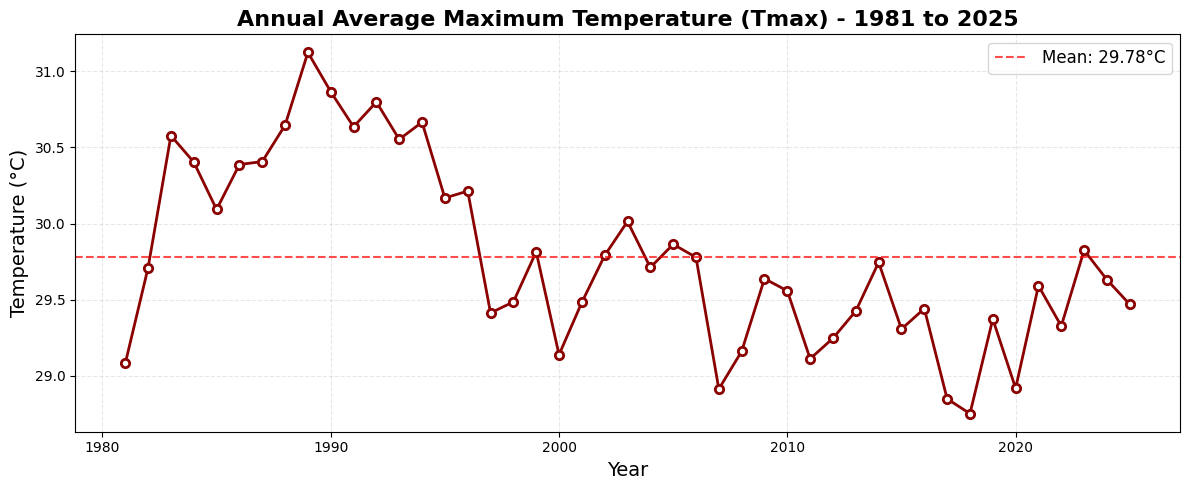

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(yearly_df.Year, yearly_df.Tmax_avg, 'o-', color='darkred', 
         linewidth=2, markersize=6, markerfacecolor='white', 
         markeredgewidth=2, markeredgecolor='darkred')
plt.title('Annual Average Maximum Temperature (Tmax) - 1981 to 2025', 
          fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=yearly_df.Tmax_avg.mean(), color='red', linestyle='--', 
            alpha=0.7, label=f'Mean: {yearly_df.Tmax_avg.mean():.2f}°C')
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

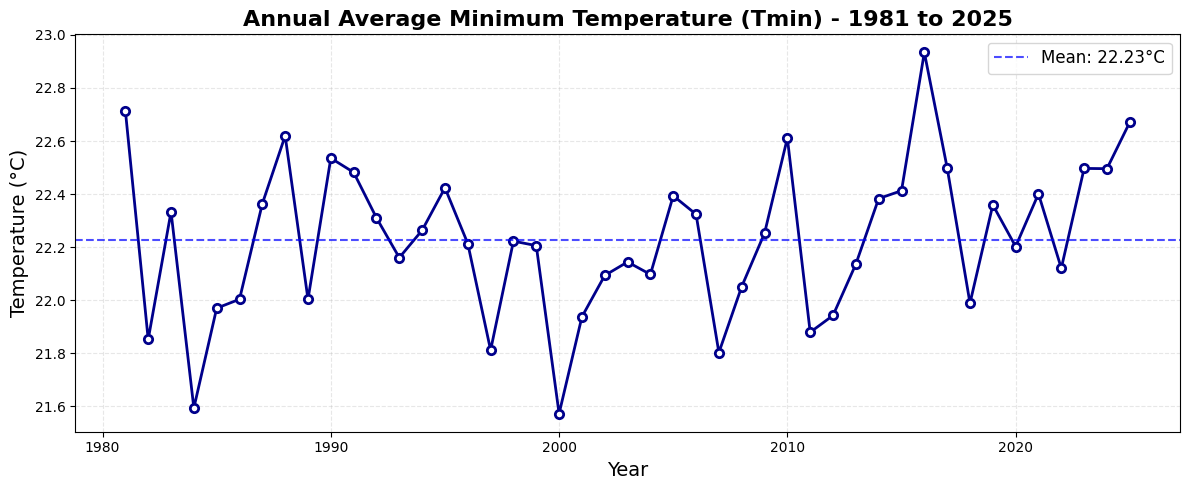

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(yearly_df.Year, yearly_df.Tmin_avg, 'o-', color='darkblue', 
         linewidth=2, markersize=6, markerfacecolor='white', 
         markeredgewidth=2, markeredgecolor='darkblue')
plt.title('Annual Average Minimum Temperature (Tmin) - 1981 to 2025', 
          fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=yearly_df.Tmin_avg.mean(), color='blue', linestyle='--', 
            alpha=0.7, label=f'Mean: {yearly_df.Tmin_avg.mean():.2f}°C')
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

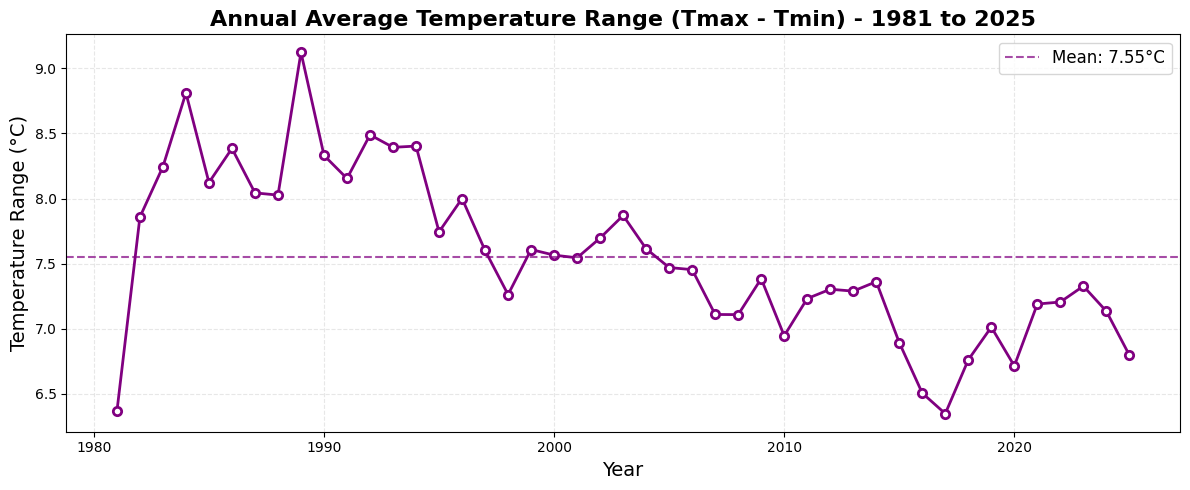

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(yearly_df.Year, yearly_df.Trange_avg, 'o-', color='purple', 
         linewidth=2, markersize=6, markerfacecolor='white', 
         markeredgewidth=2, markeredgecolor='purple')
plt.title('Annual Average Temperature Range (Tmax - Tmin) - 1981 to 2025', 
          fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature Range (°C)', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=yearly_df.Trange_avg.mean(), color='purple', linestyle='--', 
            alpha=0.7, label=f'Mean: {yearly_df.Trange_avg.mean():.2f}°C')
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

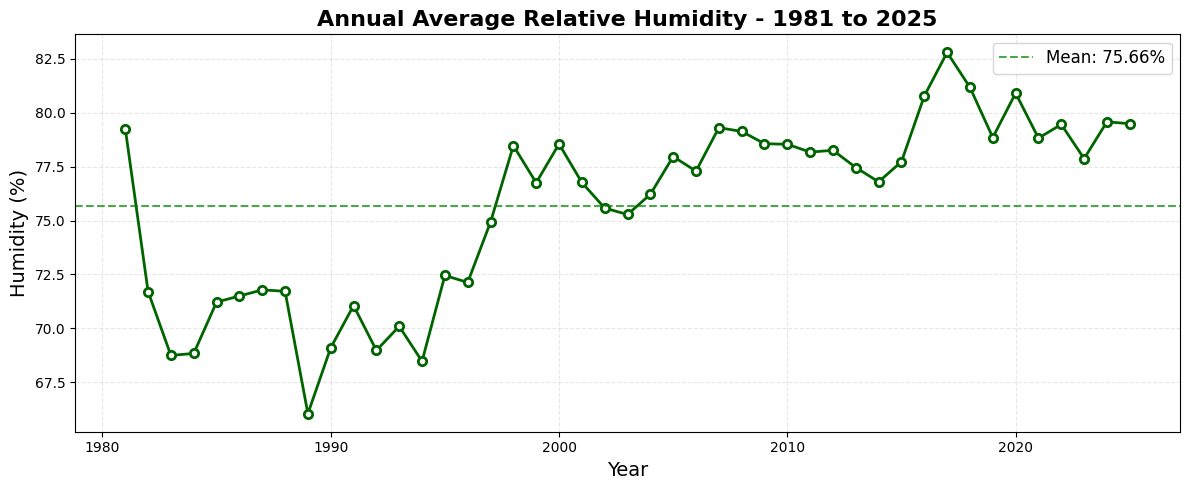

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(yearly_df.Year, yearly_df.Humidity_avg, 'o-', color='darkgreen', 
         linewidth=2, markersize=6, markerfacecolor='white', 
         markeredgewidth=2, markeredgecolor='darkgreen')
plt.title('Annual Average Relative Humidity - 1981 to 2025', 
          fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Humidity (%)', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=yearly_df.Humidity_avg.mean(), color='green', linestyle='--', 
            alpha=0.7, label=f'Mean: {yearly_df.Humidity_avg.mean():.2f}%')
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

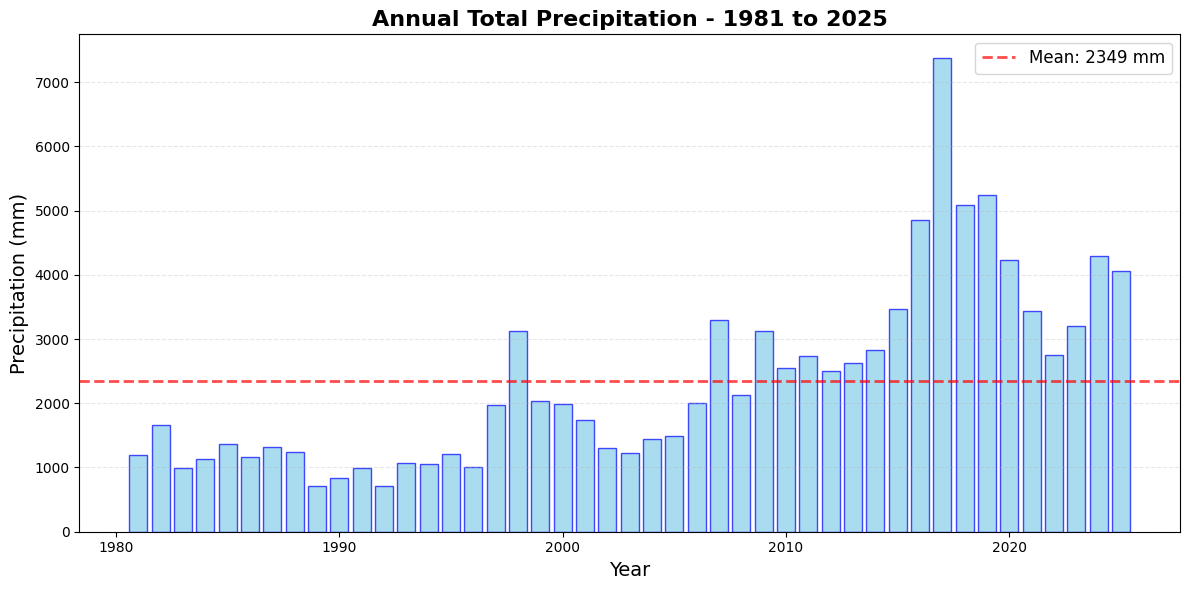

In [26]:
plt.figure(figsize=(12, 6))
plt.bar(yearly_df.Year, yearly_df.Precip_total, color='skyblue', 
        edgecolor='blue', alpha=0.7, width=0.8)
plt.title('Annual Total Precipitation - 1981 to 2025', 
          fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Precipitation (mm)', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--', axis='y')
plt.axhline(y=yearly_df.Precip_total.mean(), color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label=f'Mean: {yearly_df.Precip_total.mean():.0f} mm')
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

ALL VARIABLES IN SMALL SUBPLOTS (Grid View)

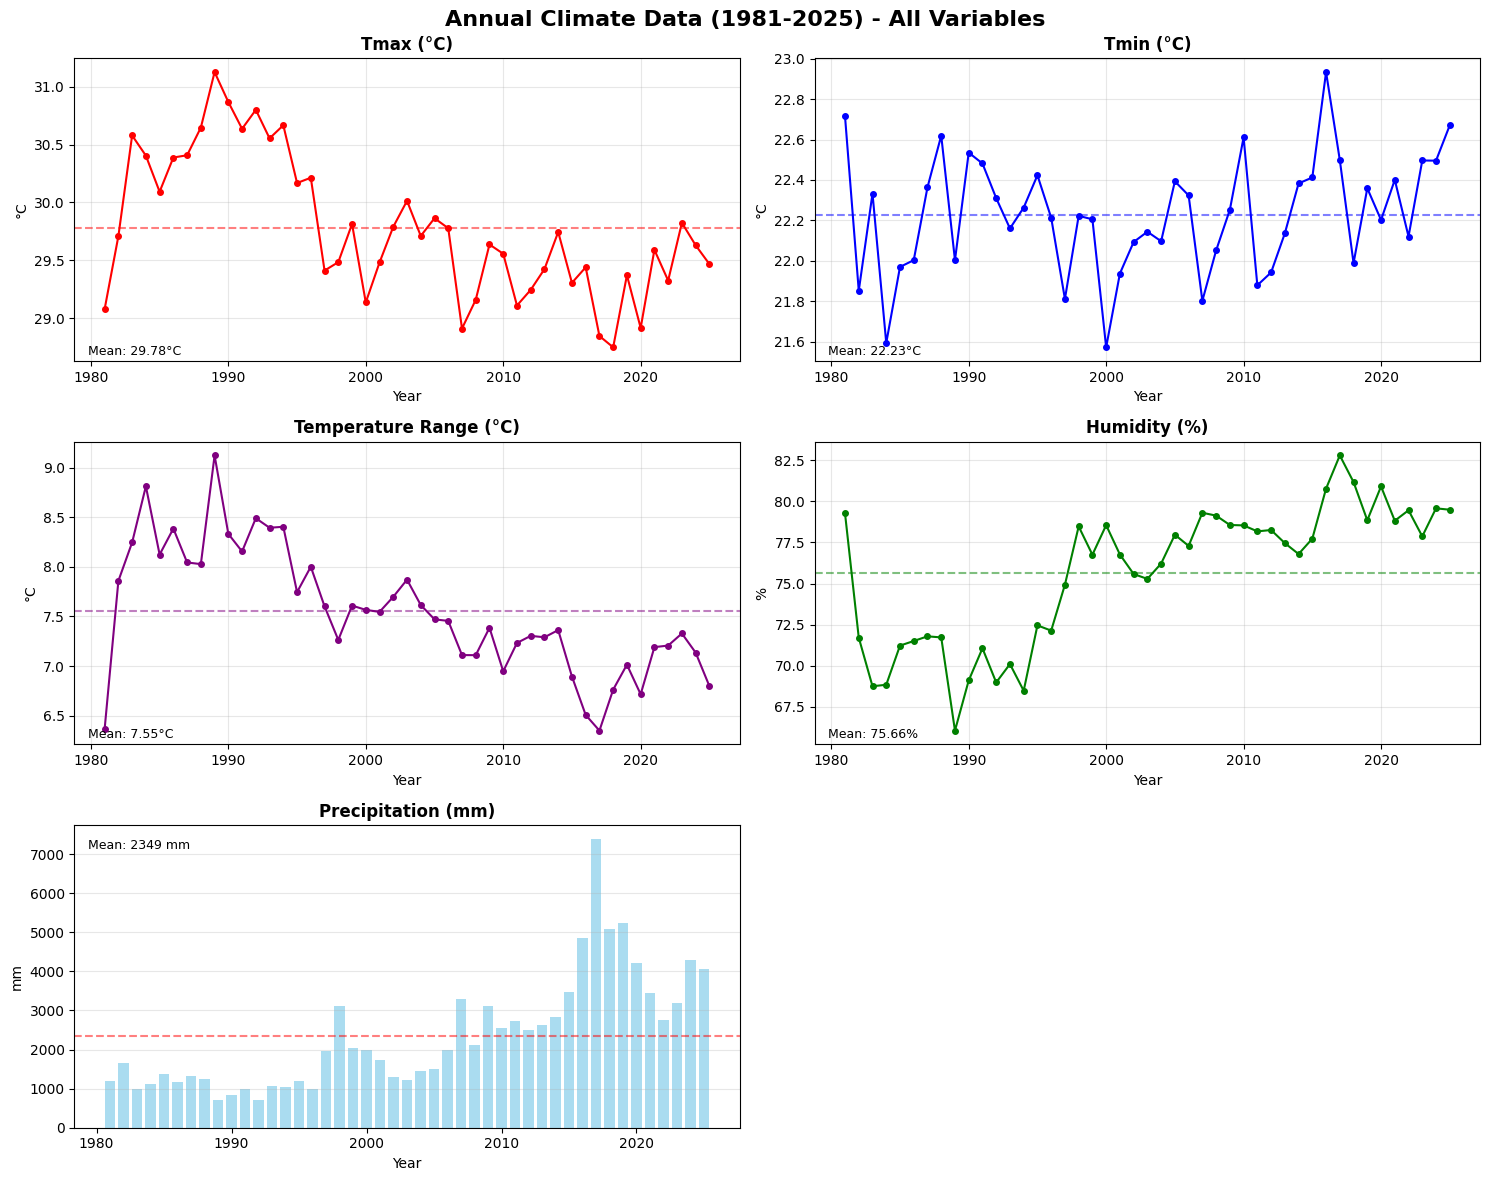

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Tmax
axes[0].plot(yearly_df.Year, yearly_df.Tmax_avg, 'o-', color='red', linewidth=1.5, markersize=4)
axes[0].set_title('Tmax (°C)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('°C')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=yearly_df.Tmax_avg.mean(), color='red', linestyle='--', alpha=0.5)
axes[0].text(0.02, 0.02, f'Mean: {yearly_df.Tmax_avg.mean():.2f}°C', transform=axes[0].transAxes, fontsize=9)

# Tmin
axes[1].plot(yearly_df.Year, yearly_df.Tmin_avg, 'o-', color='blue', linewidth=1.5, markersize=4)
axes[1].set_title('Tmin (°C)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('°C')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=yearly_df.Tmin_avg.mean(), color='blue', linestyle='--', alpha=0.5)
axes[1].text(0.02, 0.02, f'Mean: {yearly_df.Tmin_avg.mean():.2f}°C', transform=axes[1].transAxes, fontsize=9)

# Trange
axes[2].plot(yearly_df.Year, yearly_df.Trange_avg, 'o-', color='purple', linewidth=1.5, markersize=4)
axes[2].set_title('Temperature Range (°C)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('°C')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=yearly_df.Trange_avg.mean(), color='purple', linestyle='--', alpha=0.5)
axes[2].text(0.02, 0.02, f'Mean: {yearly_df.Trange_avg.mean():.2f}°C', transform=axes[2].transAxes, fontsize=9)

# Humidity
axes[3].plot(yearly_df.Year, yearly_df.Humidity_avg, 'o-', color='green', linewidth=1.5, markersize=4)
axes[3].set_title('Humidity (%)', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Year')
axes[3].set_ylabel('%')
axes[3].grid(True, alpha=0.3)
axes[3].axhline(y=yearly_df.Humidity_avg.mean(), color='green', linestyle='--', alpha=0.5)
axes[3].text(0.02, 0.02, f'Mean: {yearly_df.Humidity_avg.mean():.2f}%', transform=axes[3].transAxes, fontsize=9)

# Precipitation (bar chart)
axes[4].bar(yearly_df.Year, yearly_df.Precip_total, color='skyblue', alpha=0.7, width=0.8)
axes[4].set_title('Precipitation (mm)', fontsize=12, fontweight='bold')
axes[4].set_xlabel('Year')
axes[4].set_ylabel('mm')
axes[4].grid(True, alpha=0.3, axis='y')
axes[4].axhline(y=yearly_df.Precip_total.mean(), color='red', linestyle='--', alpha=0.5)
axes[4].text(0.02, 0.92, f'Mean: {yearly_df.Precip_total.mean():.0f} mm', transform=axes[4].transAxes, fontsize=9)

# Empty subplot
axes[5].axis('off')

plt.suptitle('Annual Climate Data (1981-2025) - All Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()